# Preprocessing Audiograms

This notebook preprocesses the audiograms in preparation for further analysis.

The steps include recalibration for a specific participant, optional removal of initialization-phase data, fixing of truncated audiograms, and resampling of the audiograms.

Specifically, the notebook performs the following operations:

1. **Recomputation**: Recomputes the audiograms for each participant. This involves fixing calibration issues for 'eqdcwr' and optionally removing the initialization data. This step is performed using the `recompute` function.

2. **Fixing Truncated Audiograms**: If the recomputed audiogram doesn't cover the entire frequency range, this step shifts the tested levels by 20 dB HL, re-does the request to the API, and then lowers the audiogram by 20 dB HL. This is done using the `fix_truncated_audiogram` function.

3. **Saving Recomputed Audiograms**: The recomputed audiograms are saved using the `save_recomputed_audiograms` function. If the recomputed audiograms have already been saved, the function fetches the previously recomputed data instead of recomputing it again.

4. **Plotting Recomputed Audiograms**: The recomputed audiograms for each participant are plotted using the `plot_recomputed_audiograms` function.

5. **Resampling Audiograms**: The audiograms are resampled to 100 data points using the `resample_audiograms` function. The resampled audiograms are then plotted.

This notebook should be run after fixing the Continuous responses with the notebook `fix_continuous_responses.ipynb`, as it creates the data files this script reads from. Otherwise, no data will be found for the Continuous paradigm (no files suffixed `*_fixed.pkl`)


In [1]:
import os
import sys

from matplotlib import cm

sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom functions
from scripts.utils import *
from funcs.resample_audiograms import *

### Set some parameters

In [2]:
# Set path to raw data
raw_data_path = get_path("raw_data")

# Choose whether to keep init data or recompute audiograms without them
remove_init = False
aud_path = os.path.join(get_path("audiograms"), "no_init" if remove_init else "with_init")

# Choose participants to exclude
ignore_participants = exclude_participants()
participants = [participant for participant in os.listdir(raw_data_path) if participant not in ignore_participants]

# Get API url and headers
url_api, headers = get_API_access()

overwrite_existing_audiograms = True

preds = ['none', 'time', 'frequency', 'both']
AFC_freqs = [125, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000]
freq_range = 125, 8000
xfreqs = np.geomspace(freq_range[0], freq_range[1], num=100)  # for resampling

colormap = cm.get_cmap('turbo', len(participants))

### Randomized paradigm

#### Load and recompute Randomized data

In [3]:
print("------------------------ BAYESIAN DATA ------------------------")
paradigm = 'Bayesian'

os.chdir(raw_data_path)

raw_data_Bayes = {}
init_dataB = {}

for participant in participants:

    # Fetch Bayesian data
    print(os.path.join(raw_data_path, participant, paradigm))
    raw_data_Bayes[participant] = fetch_audiogram_data(raw_data_path, participant, paradigm)
    if raw_data_Bayes[participant] is not None:
        # Fetch initialization phase data
        raw_data_Bayes[participant]['init'] = fetch_audiogram_data(raw_data_path, participant, paradigm, init=True)
    else:
        print(f"No audiogram found for participant {participant}...")
        ignore_participants.append(participant)


bayes_aud_dir = set_audiograms_directory(aud_path, paradigm)

# os.chdir(aud_dir)

# Recompute audiograms if needed, or load already recomputed audiograms
recomputed_Bayes = load_or_recompute_and_save_audiograms(raw_data_Bayes,
                                                         bayes_data=raw_data_Bayes,
                                                         ignore_participants=ignore_participants,
                                                         paradigm=paradigm,
                                                         remove_initialization=remove_init,
                                                         aud_dir=bayes_aud_dir,
                                                         url_api=url_api,
                                                         headers=headers,
                                                         overwrite=overwrite_existing_audiograms
                                                         )

------------------------ BAYESIAN DATA ------------------------
/Users/nadou/Projects/there_will_be_beeps/data/raw_data/tlvjds/Bayesian
Opening audiogram for tlvjds: (Bayesian)...
tlvjds_Bayesian_2022-05-06_11h12.28.510_audiogram.pkl
Opening audiogram for tlvjds: (Bayesian)...
tlvjds_Bayesian_2022-05-06_11h12.28.510_init.pkl
/Users/nadou/Projects/there_will_be_beeps/data/raw_data/nlhglm/Bayesian
Opening audiogram for nlhglm: (Bayesian)...
nlhglm_Bayesian_2022-05-09_14h42.58.204_audiogram.pkl
Opening audiogram for nlhglm: (Bayesian)...
nlhglm_Bayesian_2022-05-09_14h42.58.204_init.pkl
/Users/nadou/Projects/there_will_be_beeps/data/raw_data/klxufm/Bayesian
Opening audiogram for klxufm: (Bayesian)...
klxufm_Bayesian_2022-05-09_16h49.09.350_audiogram.pkl
Opening audiogram for klxufm: (Bayesian)...
klxufm_Bayesian_2022-05-09_16h49.09.350_init.pkl
/Users/nadou/Projects/there_will_be_beeps/data/raw_data/rdzaqd/Bayesian
Opening audiogram for rdzaqd: (Bayesian)...
rdzaqd_Bayesian_2022-05-06_14h0

## Cluster paradigm


#### Load and recompute Cluster data

In [4]:
print("------------------------------ CLUSTER DATA ------------------------------")
paradigm = 'Cluster'

clus_aud_dir = set_audiograms_directory(aud_path, paradigm)

raw_data_Clus = {}
recomputed_Clus = {}

for pred in preds:
    print("\n-------------", pred.upper(), "-------------\n")
    os.chdir(raw_data_path)
    raw_data_Clus[pred] = {}

    for participant in participants:
        if participant not in raw_data_Clus[pred].keys():
            raw_data_Clus[pred][participant] = fetch_audiogram_data(raw_data_path, participant, paradigm, pred)


    recomputed_Clus[pred] = load_or_recompute_and_save_audiograms(raw_data_Clus[pred],
                                                                  bayes_data=raw_data_Bayes,
                                                                  paradigm=paradigm,
                                                                  ignore_participants=ignore_participants,
                                                                  pred=pred,
                                                                  remove_initialization=remove_init,
                                                                  aud_dir=clus_aud_dir,
                                                                  url_api=url_api,
                                                                  headers=headers,
                                                                  overwrite=overwrite_existing_audiograms
                                                                  )


------------------------------ CLUSTER DATA ------------------------------

------------- NONE -------------

Opening audiogram for tlvjds: (Cluster/none)...
tlvjds_Cluster_2022-05-06_11h58.32.052_none_audiogram.pkl
Opening audiogram for nlhglm: (Cluster/none)...
nlhglm_Cluster_2022-05-09_14h49.52.594_none_audiogram.pkl
Opening audiogram for klxufm: (Cluster/none)...
klxufm_Cluster_2022-05-09_16h56.39.686_none_audiogram.pkl
Opening audiogram for rdzaqd: (Cluster/none)...
rdzaqd_Cluster_2022-05-06_14h32.44.031_none_audiogram.pkl
Opening audiogram for vqnuwy: (Cluster/none)...
vqnuwy_Cluster_2022-05-10_10h33.47.531_none_audiogram.pkl
Opening audiogram for wfoooa: (Cluster/none)...
wfoooa_Cluster_2022-05-04_11h35.25.053_none_audiogram.pkl
Opening audiogram for cbtxie: (Cluster/none)...
cbtxie_Cluster_2022-05-05_16h25.21.942_none_audiogram.pkl
Opening audiogram for udoety: (Cluster/none)...
udoety_Cluster_2022-05-03_12h07.59.148_none_audiogram.pkl
Opening audiogram for cwzopc: (Cluster/non

## Continuous paradigm

### Load and recompute Continuous audiograms

In [5]:
print("------------------------------ CONTINUOUS DATA ------------------------------")
paradigm = 'Continuous'
cont_aud_dir = set_audiograms_directory(aud_path, 'Continuous')

raw_data_Con = {}
recomputed_Con = {}

for pred in preds:
    print(pred.upper())
    # os.chdir(raw_data_path)
    raw_data_Con[pred] = {}

    for participant in participants:
    # for participant in os.listdir():  # ['rehvhf']:  #
        if participant not in raw_data_Con[pred].keys():
            raw_data_Con[pred][participant] = fetch_audiogram_data(raw_data_path, participant, paradigm, pred)

    recomputed_Con[pred] = load_or_recompute_and_save_audiograms(raw_data_Con[pred],
                                                                raw_data_Bayes,
                                                                paradigm=paradigm,
                                                                ignore_participants=ignore_participants,
                                                                aud_dir=cont_aud_dir,
                                                                url_api=url_api,
                                                                headers=headers,
                                                                pred=pred,
                                                                remove_initialization=remove_init,
                                                                 overwrite=overwrite_existing_audiograms
                                                                )

------------------------------ CONTINUOUS DATA ------------------------------
NONE
Opening audiogram for tlvjds: (Continuous/none)...
tlvjds_Continuous_none_fixed.pkl
Opening audiogram for nlhglm: (Continuous/none)...
nlhglm_Continuous_none_fixed.pkl
Opening audiogram for klxufm: (Continuous/none)...
klxufm_Continuous_none_fixed.pkl
Opening audiogram for rdzaqd: (Continuous/none)...
rdzaqd_Continuous_none_fixed.pkl
Opening audiogram for vqnuwy: (Continuous/none)...
vqnuwy_Continuous_none_fixed.pkl
Opening audiogram for wfoooa: (Continuous/none)...
wfoooa_Continuous_none_fixed.pkl
Opening audiogram for cbtxie: (Continuous/none)...
cbtxie_Continuous_none_fixed.pkl
Opening audiogram for udoety: (Continuous/none)...
udoety_Continuous_none_fixed.pkl
Opening audiogram for cwzopc: (Continuous/none)...
cwzopc_Continuous_none_fixed.pkl
Opening audiogram for ofgjwt: (Continuous/none)...
ofgjwt_Continuous_none_fixed.pkl
Opening audiogram for erfnpg: (Continuous/none)...
erfnpg_Continuous_none_fix

## Plot recomputed audiograms

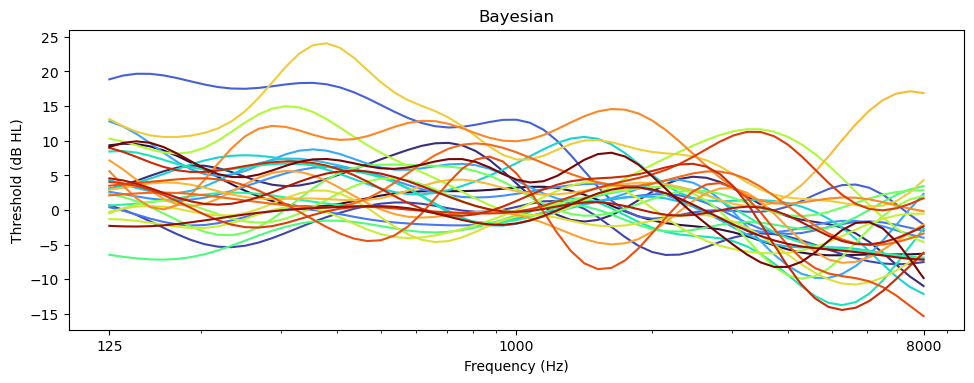

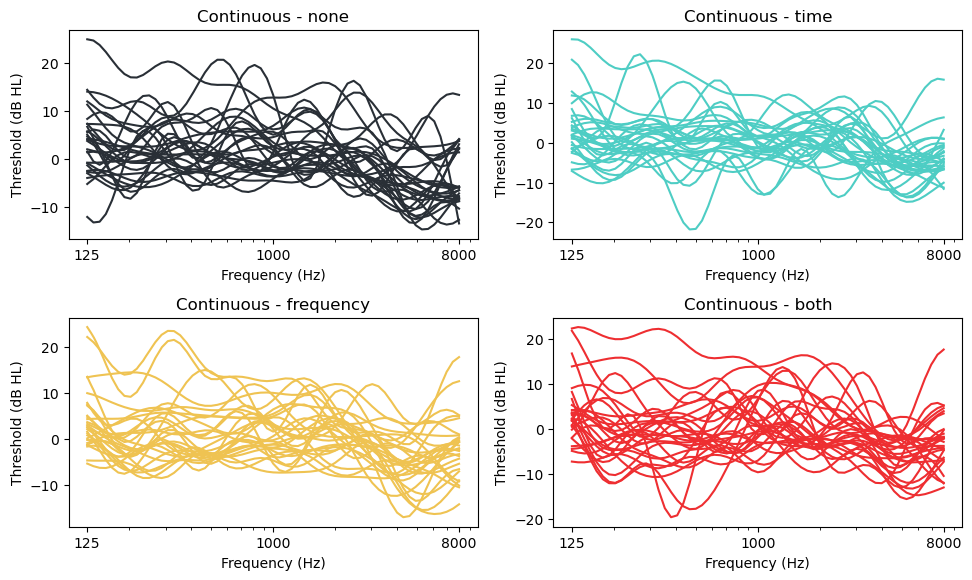

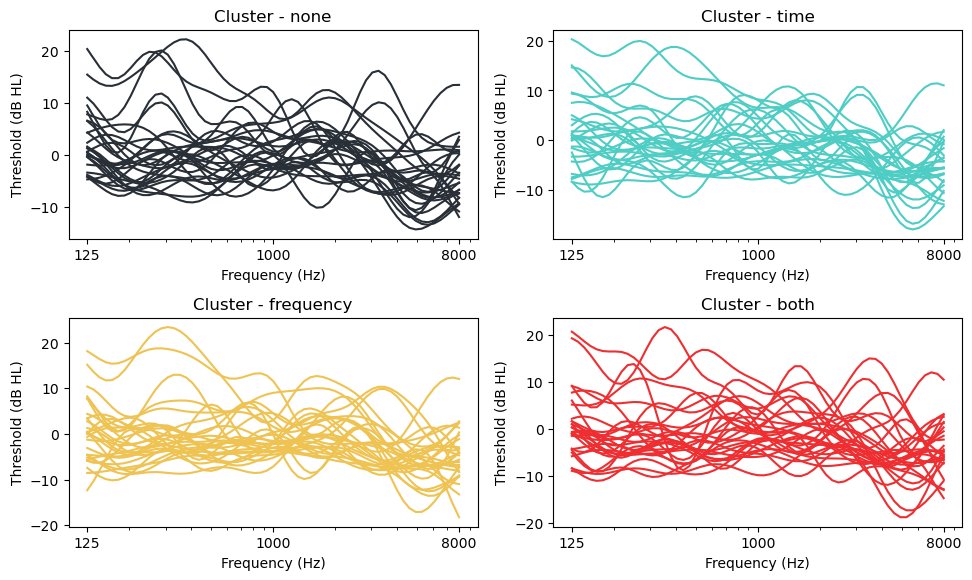

In [6]:
# Randomized
plt.figure(figsize=[25/2.54, 10/2.54])
plot_recomputed_audiograms(recomputed_Bayes, paradigm='Bayesian', colormap=colormap)
plt.tight_layout()
plt.show()

# Continuous
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    plot_recomputed_audiograms(recomputed_Con[pred], paradigm="Continuous", pred=pred)
    # plt.legend(preds)
plt.tight_layout()
plt.show()

# Cluster
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    plot_recomputed_audiograms(recomputed_Clus[pred], paradigm='Cluster', pred=pred)
    # plt.legend(preds)
plt.tight_layout()
plt.show()

## Resampling

### Perform resampling

In [7]:
resampled_Bayes = load_or_resample_and_save_audiograms('Bayesian',
                                                       recomputed_Bayes,
                                                       xfreqs,
                                                       remove_initialization=remove_init,
                                                       aud_dir=bayes_aud_dir,
                                                       overwrite=overwrite_existing_audiograms
                                                       )

resampled_Cluster = {}
resampled_Continuous = {}

for pred in preds:
    resampled_Cluster[pred] = \
        load_or_resample_and_save_audiograms('Cluster',
                                             recomputed_Clus[pred],
                                             xfreqs,
                                             remove_initialization=remove_init,
                                             aud_dir=clus_aud_dir,
                                             overwrite=overwrite_existing_audiograms,
                                             pred=pred
                                             )

    resampled_Continuous[pred] = \
        load_or_resample_and_save_audiograms('Continuous',
                                             recomputed_Con[pred],
                                             xfreqs,
                                             remove_initialization=remove_init,
                                             aud_dir=cont_aud_dir,
                                             overwrite=overwrite_existing_audiograms,
                                             pred=pred
                                             )


---------------- Bayesian ----------------
Saving resampled audiogram of tlvjds in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of nlhglm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of klxufm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of rdzaqd in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of vqnuwy in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of wfoooa in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of cbtxie in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of udoety in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of cwzopc in there_will_be_beeps/data/audiograms/with_init/Bayesian...
Saving resampled audiogram of ofgjwt in there_will_be_beeps/data/audiograms

### Plot resampled data

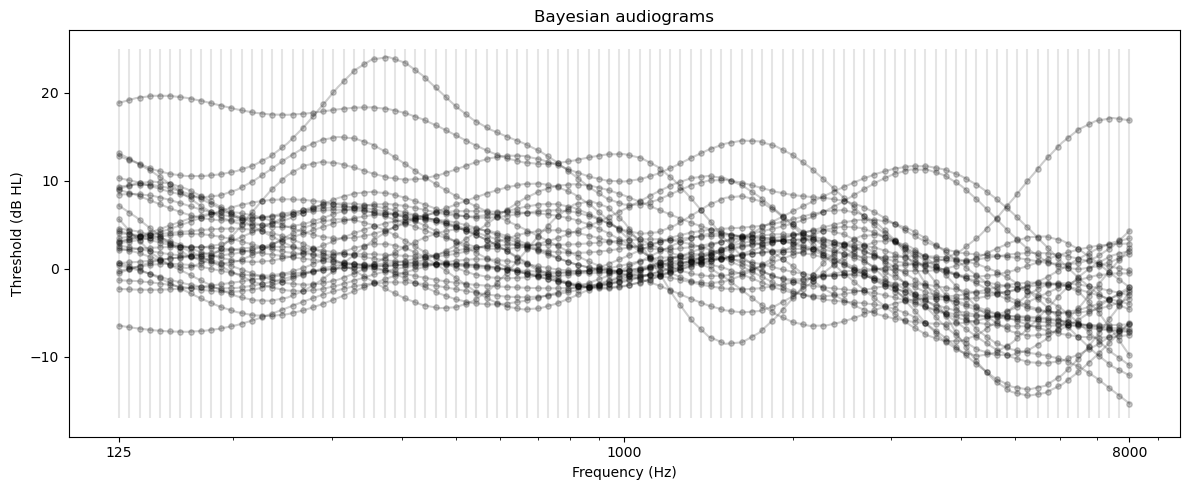

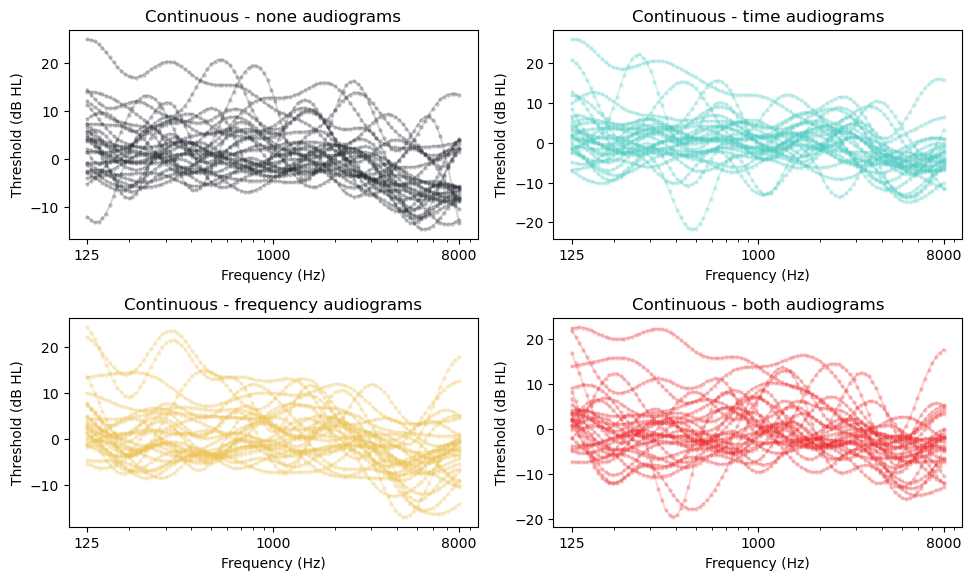

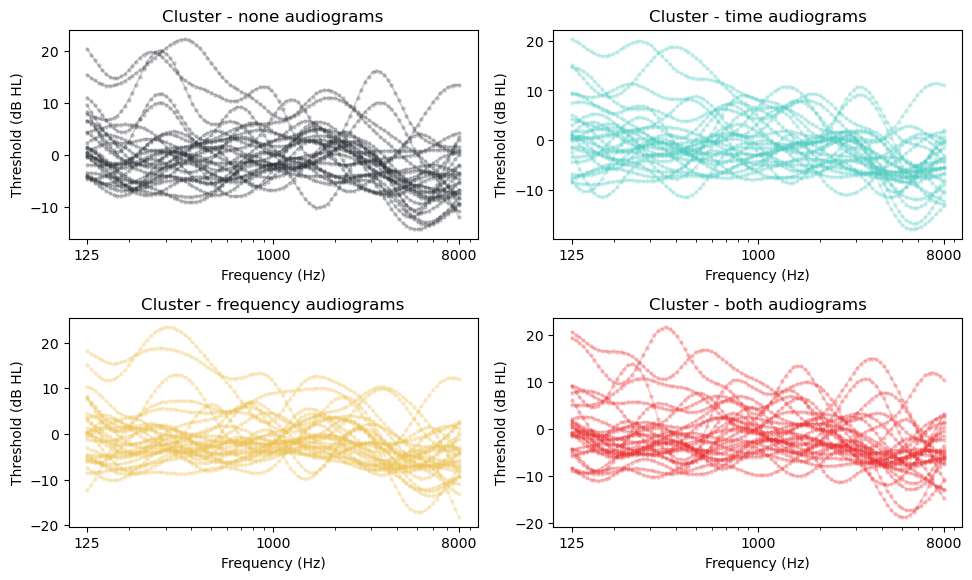

In [8]:
# Randomized
plt.figure(figsize=[12, 5])
plt.vlines(xfreqs, -17, 25, colors='k', alpha=.1)
plot_resampled_audiograms(recomputed_Bayes, resampled_Bayes, xfreqs, paradigm='Bayesian')
plt.tight_layout()
plt.show()

# Continuous
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    plot_resampled_audiograms(recomputed_Con[pred], resampled_Continuous[pred], xfreqs, paradigm='Continuous', pred=pred)
plt.tight_layout()
plt.show()

# Cluster
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    plot_resampled_audiograms(recomputed_Clus[pred], resampled_Cluster[pred], xfreqs, paradigm='Cluster', pred=pred)
plt.tight_layout()
plt.show()
